In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results = pd.read_excel('../../results/experimental/cell-based-assays.xlsx', 'Sheet2', header=[0, 1, 2])
results = results.set_index(('class', 'assay', 'concentration'))
results = results.drop(results.columns[0], axis=1)
results = results.transpose()
results = results.rename_axis(['class', 'assay', 'concentration'], axis='index')
results['conc'] = results.index.get_level_values('concentration')
results

('class', 'assay', 'concentration')                                                Chenodiol (TUDCA)  \
class                                          assay                concentration                      
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1                           NaN   
                                                                    c2                           NaN   
                                                                    c3                           NaN   
Exp3 Abeta Clearance BV2                       Abeta in SN          c4                           0.0   
                                                                    c5                           0.0   
...                                                                                              ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2                           0.0   
                                                                    c3                           0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c4                           NaN   
                                                                    c5                           NaN   
                                                                    c6                           NaN   

('class', 'assay', 'concentration')                                                Cysteamine HCl (Cysteamine)  \
class                                          assay                concentration                                
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1                                     NaN   
                                                                    c2                                     NaN   
                                                                    c3                                     NaN   
Exp3 Abeta Clearance BV2                       Abeta in SN          c4                                     0.0   
                                                                    c5                                     1.0   
...                                                                                                        ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2                                     0.0   
                                                                    c3                                     0.0   
Exp9 Tau Agg cell-free                         Tau aggregation ΔRFU c4                                     NaN   
                                                                    c5                                     NaN   
                                                                    c6                                     NaN   

('class', 'assay', 'concentration')                                                Arundine (3,3'-Diindolylmethane)  \
class                                          assay                concentration                                     
Exp2 Abeta induced toxicity primary neurons    MTT (viability)      c1                                          NaN   
                                                                    c2                                          NaN   
                                                                    c3                                          NaN   
Exp3 Abeta Clearance BV2                       Abeta in SN          c4                                          0.0   
                                                                    c5                                         -1.0   
...                                                                                                             ...   
Exp8 trophic factor withdrawal primary neurons LDH (cell death)     c2                                          0.0   
                                                                    c3                       

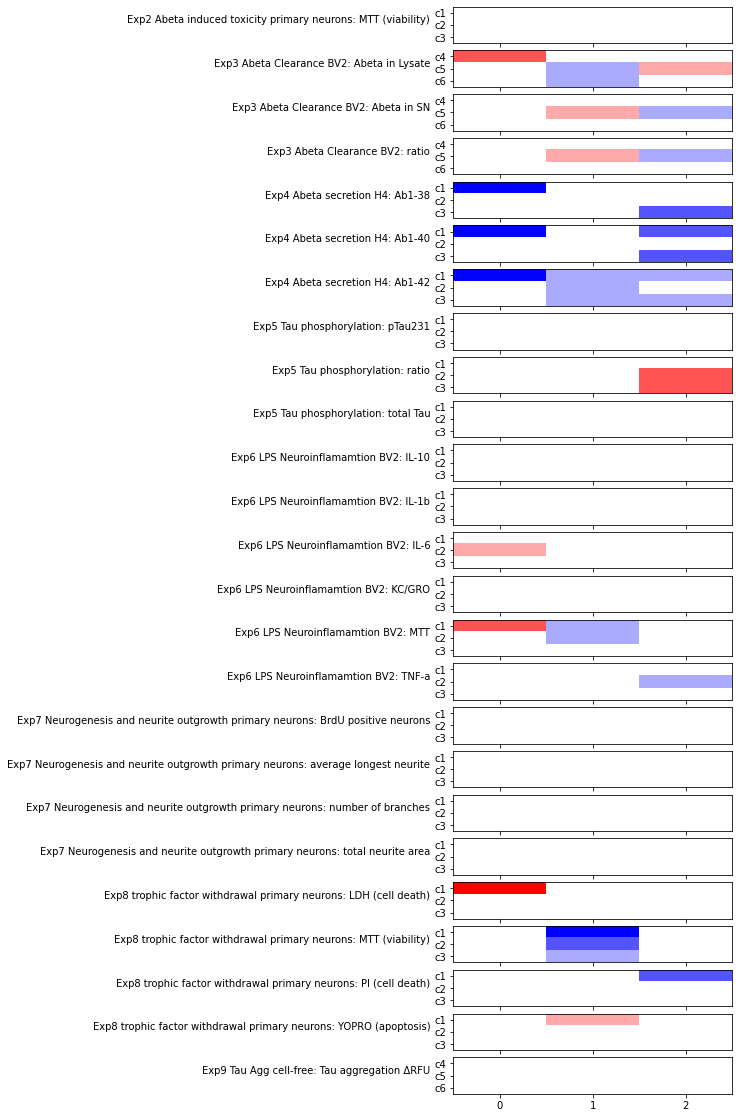

In [3]:
gb = results.groupby(['class', 'assay'])
fig, ax = plt.subplots(len(gb), 1, figsize=(5, 20))
for axi, gb1 in zip(ax, gb):
    name, df = gb1
    axi.imshow(df.iloc[:, range(3)], aspect='auto', interpolation='none', cmap='bwr', vmin=-3, vmax=3)
    axi.set_xticks(range(3))
    axi.set_yticks(range(df.shape[0]))
    axi.set_yticklabels(df.conc)
    axi.set_ylabel(': '.join(name), rotation=0, horizontalalignment='right')
#ax.set_xticklabels(results.columns, rotation=-45, horizontalalignment='left')

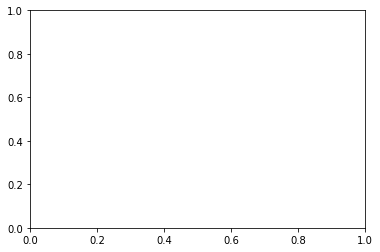

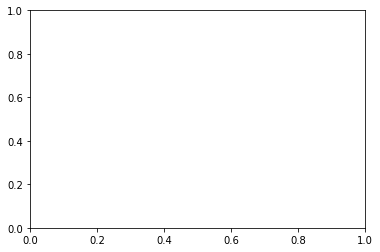

In [4]:
fig, ax = plt.subplots()
fig, ax = plt.subplots()

In [5]:
%connect_info

{
  "shell_port": 57757,
  "iopub_port": 57758,
  "stdin_port": 57759,
  "control_port": 57761,
  "hb_port": 57760,
  "ip": "127.0.0.1",
  "key": "192b6eda-fcf68202299b329a540fc75a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-da6a8744-3d2b-473c-90e7-75c28a21a897.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
